# NNDL - Homework 1
## Rosset Lorenzo - 2021859

In [16]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import sklearn as sk
from sklearn.model_selection import KFold

# Regression Task

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset and dataloader

In [2]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2021-11-07 17:17:23--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2021-11-07 17:17:24 (50.4 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2021-11-07 17:17:24--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv’

test_data.csv 

In [3]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

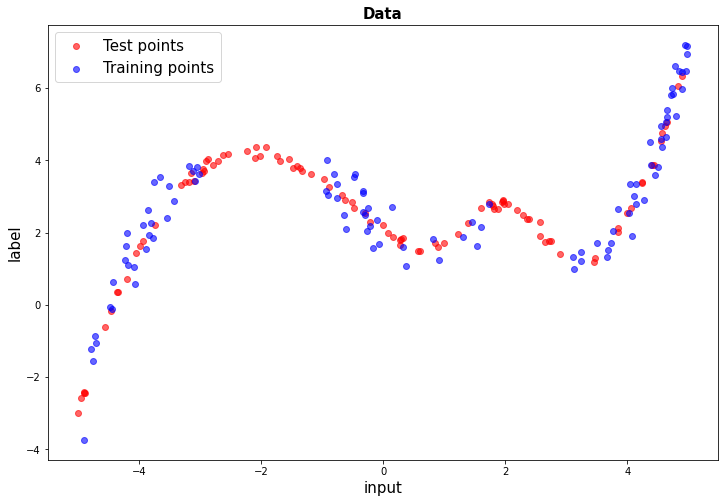

In [4]:
fig = plt.figure(figsize=(12,8))
plt.scatter(test_df.input, test_df.label, label='Test points', alpha=0.6, c='red')
plt.scatter(train_df.input, train_df.label, label='Training points', alpha=0.6, c='blue')
plt.xlabel('input', size=15)
plt.ylabel('label', size=15)
plt.title('Data', size=15, fontweight='bold')
plt.legend(fontsize=15)
plt.show()

### Dataset

In [5]:
# Dataset class
class RegressionDataset(Dataset):
    
    def __init__(self, csv_file, transform=None):
        self.transform = transform
        self.df = pd.read_csv(csv_file)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sample = (row[0], row[1])
        if self.transform:
            sample = self.transform(sample)
        return sample

# Transforms class
class ToTensor(object):

    def __call_(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [15]:
composed_transform = transforms.Compose([ToTensor()])
train_dataset = RegressionDataset('regression_dataset/train_data.csv', transform=transforms.ToTensor())
test_dataset = RegressionDataset('regression_dataset/test_data.csv', transform=transforms.ToTensor())

print('Training set size:', len(train_dataset))
print('Test set size:', len(test_dataset))

Training set size: 100
Test set size: 100


In [17]:
# Define the K-fold cross validation
k_folds = 5
num_epochs = 1 # To modify!
Kfold = KFold(n_splits=k_folds, shuffle=True)

### Dataloader

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
test_dataloader = DataLoader(train_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)

## Training loop

In [9]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [10]:
# Network architecture
class RegNet(nn.Module):

    def __init__(self, Nin, N1, N2, Nout):
        super().__init__()
        self.l1 = nn.Linear(in_features=Nin, out_features=N1)
        self.l2 = nn.Linear(in_features=N1, out_features=N2)
        self.l3 = nn.Linear(in_features=N2, out_features=Nout)
        self.act = nn.ReLU()
    
    def forward(self, x, additional_out=False):
        x = self.act(self.l1(x))
        x = self.act(self.l2(x))
        x = self.l3(x)
        return x

In [11]:
# Initialize the network
torch.manual_seed(0)
Nin = 1
N1 = 128
N2 = 256
Nout = 1
regnet = RegNet(Nin, N1, N2, Nout)
regnet.to(device)

RegNet(
  (l1): Linear(in_features=1, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=1, bias=True)
  (act): ReLU()
)

In [12]:
# Loss function
loss_fn = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(regnet.parameters(), lr=1e-3)

In [ ]:
# Training loop
num_epochs = 100
train_loss_log = []